<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Заказчик:** 
Интернет-магазин «Викишоп» 


**Описание проекта:** 
заказчик запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**

Датасет содержит тексты комментариев, а также целевой признак — является ли комментарий токсичным.

**Цель проекта:**

Обучить модель классифицировать комментарии на позитивные и негативные. Соответственно, в ходе проекта будет решена задача бинарной классификации.

Необходимо, чтобы метрика качества *F1* имела значение не меньше 0.75. 

**Ход исследования**
- **Подготовка данных**: загрузка и изучение общей информации о предоставленном датасете. Корректировка типов данных, дубликатов и пропусков. Токенизация, лемматизация, векторизация текстов. Разбивка данных на выборки перед обучением моделей.

- **Обучение и оценка моделей**: обучение моделей для задачи классификации. Оценка качества, выбор лучшей модели  и её проверка на тестовой выборке.

- **Общий вывод** и подведение итогов по проделанным работам, рекомендации заказчику.

In [1]:
!pip install --upgrade scikit-learn -q
!pip install wordcloud==1.8.2.2 -q
!pip install vaderSentiment -q
!pip install --upgrade Pillow -q

In [2]:
import os

import numpy as np
import scipy.stats as stats

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from itertools import product

from tqdm.notebook import tqdm

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

RANDOM_STATE = 42

## Подготовка
<a href="#Содержание">Назад к содержанию</a>

Для начала загрузим данные. Применим библиотеку os, чтобы убедиться в корректности пути, по которому находится датасет.

In [3]:
pth = '/comments.csv'
if os.path.exists(pth):
    toxic_comments = pd.read_csv(pth)
    display(toxic_comments.head(), toxic_comments.shape)
else:
    print('Something is wrong')

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


(159292, 3)

Всего в датасете 3 признака и 159292 наблюдения. Помимо текстов и таргета присутствует лишний признак «Unnamed: 0». Он дублирует индекс датасета и не имеет значения для дальнейшего обучения, удалим его.

In [4]:
toxic_comments = toxic_comments.drop('Unnamed: 0', axis=1)
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим данные на наличие пропусков.

In [5]:
toxic_comments.isna().sum()

text     0
toxic    0
dtype: int64

Пропуски отсутствуют, проверим наличие дубликатов.

In [6]:
toxic_comments.duplicated(subset='text').sum()

0

Одинаковые тексты отсутствуют. Убедимся, что таргет принимает только 2 значения — 1 и 0.

In [7]:
toxic_comments['toxic'].unique()

array([0, 1])

Убедимся в корректности типов данных:

In [8]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Типы данных распределены корректно. Теперь проанализируем распределение меток класса.

'Частота значений для признака: toxic'

0    143106
1     16186
Name: toxic, dtype: int64

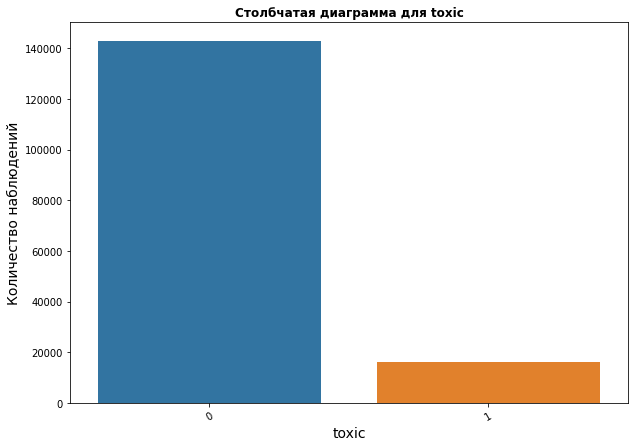

In [9]:
plt.figure(figsize=(10, 7))

sns.countplot(data=toxic_comments, x='toxic')
plt.title('Столбчатая диаграмма для toxic', fontweight='bold')
plt.ylabel('Количество наблюдений', fontsize=14)
plt.xlabel('toxic', fontsize=14)
plt.xticks(rotation=30)
display('Частота значений для признака: toxic',
        toxic_comments['toxic'].value_counts()
       ) 
plt.show()  

Негативных текстов в разы меньше (в 8.84 раза). При разбиении данных на выборки необходимо будет учесть дисбаланс классов.

Загружены предсказанные классы из файла.


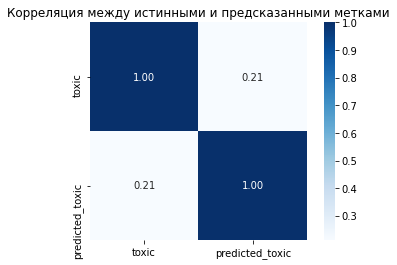

In [10]:
analyzer = SentimentIntensityAnalyzer()

tqdm.pandas()
predicted_file = 'predicted_toxic.csv'

def get_predicted_class(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    # compound <= 0 - класс 1 (негативный), > 0 - класс 0 (позитивный)
    return 1 if compound <= 0 else 0

try:    
    predicted_data = pd.read_csv(predicted_file)
    toxic_comments['predicted_toxic'] = predicted_data['predicted_toxic']
    print("Загружены предсказанные классы из файла.")
    
except FileNotFoundError:
    toxic_comments['predicted_toxic'] = toxic_comments['text'].progress_apply(get_predicted_class)
    toxic_comments[['predicted_toxic']].to_csv(predicted_file, index=False)
    print("Предсказанные классы рассчитаны и сохранены в файл.")

sns.heatmap(toxic_comments[['toxic', 'predicted_toxic']].corr(), annot=True, fmt='.2f', cmap='Blues', square=True)
plt.title('Корреляция между истинными и предсказанными метками')
plt.show()

Между фактическими метками классов и оценками SentimentIntensityAnalyzer корреляция слабая положительная — 0.21

Теперь проведем токенизацию и лемматизацию текста с помощью функции.

In [11]:
nlp = spacy.load('en_core_web_sm')

tqdm.pandas()
stop_words = set(nlp.Defaults.stop_words)

def preprocess_text(text):
    doc = nlp(text)
    lemmatized_tokens = [
        token.lemma_.lower() 
        for token in doc 
        if token.is_alpha and not token.is_stop
    ]
    return lemmatized_tokens

output_file = 'lemmatized_comments.pkl'

try:
    toxic_comments = pd.read_pickle(output_file)
    print("Данные загружены из файла:", output_file)
    
except FileNotFoundError:
    toxic_comments['text'] = toxic_comments['text'].progress_apply(preprocess_text)
    toxic_comments.to_pickle(output_file)
    print("Данные сохранены в файл:", output_file)

toxic_comments.head()

Данные загружены из файла: lemmatized_comments.pkl


,text,toxic
0,"[explanation, edit, username, hardcore, metall...",0
1,"[match, background, colour, seemingly, stuck, ...",0
2,"[hey, man, try, edit, war, guy, constantly, re...",0
3,"[real, suggestion, improvement, wonder, sectio...",0
4,"[sir, hero, chance, remember, page]",0


Теперь разобъём данные на тренировочную и тестовые выборки с параметром stratify — чтобы пропорции классов сохранились во всех выборках.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    toxic_comments.drop('toxic', axis=1),
    toxic_comments['toxic'],
    test_size= .2,
    random_state=RANDOM_STATE,
    stratify=toxic_comments['toxic']
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(127433, 1) (31859, 1) (127433,) (31859,)


Для обучения моделей далее потребуется провести векторизацию. Сделаем это с помощью TfidfVectorizer. Чтобы не сломать ядро jupiter, не будем преобразовывать эти данные в массив и затем в датафрейм — оставим в виде разреженной матрицы.

In [13]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train['text'].progress_apply(lambda tokens: ' '.join(tokens)))
X_test = vectorizer.transform(X_test['text'].progress_apply(lambda tokens: ' '.join(tokens)))
print(X_train.shape, X_test.shape, type(X_train), type(X_test))

  0%|          | 0/127433 [00:00<?, ?it/s]

  0%|          | 0/31859 [00:00<?, ?it/s]

(127433, 129194) (31859, 129194) <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>


In [14]:
print(type(X_train), type(X_test))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>


**Вывод по подготовке данных**

- Изначальная размерность датасета — (159292 строк, 3 признака);
- Признак «Unnamed: 0» дублирует индекс датасета и не имеет значения для дальнейшего обучения. Он был удалён;
- Пропуски и дубликаты в датасете отсутствуют, типы данных назначены корректно;
- Проведена токенизация, лемматизация и векторизация текстов;
- Проведена разбивка на тренировочную и тестовую выборки (80% и 20% датасета соответственно).
- Негативных текстов в разы меньше, чем позитивных (в 8.84 раза). Это говорит о наличии дисбаланса классов;
- Между фактическими метками классов и оценками SentimentIntensityAnalyzer корреляция слабая положительная — 0.21.

## Обучение
<a href="#Содержание">Назад к содержанию</a>

Далее обучим 3 модели: логистическую регрессию, дерево решений, к-ближайших соседей. Оценим метрику их качества на кроссвалидации с помощью GridSearchCV.

In [15]:
pipeline = Pipeline(
    steps=[
    (
        'model', DecisionTreeClassifier(random_state=RANDOM_STATE)
    )  
]
)

param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5],
    },
    {
       'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
       'model__C': np.linspace(0.1, 3, 10),
    }
]

search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
best_params = search.best_params_
best_score = search.best_score_

display(F"Лучшая модель: {best_model}")
display(f"Лучшие параметры: {best_params}")
display(f"Метрика лучшей модели на кросс-валидации: {best_score}") 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


"Лучшая модель: Pipeline(steps=[('model',\n                 LogisticRegression(C=2.6777777777777776, penalty='l1',\n                                    random_state=42, solver='liblinear'))])"

"Лучшие параметры: {'model': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'model__C': 2.6777777777777776}"

'Метрика лучшей модели на кросс-валидации: 0.774407209817857'

Лучшей моделью оказалась LogisticRegression с параметрами penalty='l1', random_state=42, solver='liblinear' C=2.6777777777777776. Далее проверим её качество на тестовой выборке и сравним результат с дамми-классификатором.

In [16]:
best_preds = search.best_estimator_.predict(X_test)
display(f'Метрика f1 для лучшей модели на тестовой выборке: {f1_score(y_test, best_preds):.4f}')

'Метрика f1 для лучшей модели на тестовой выборке: 0.7811'

In [17]:
dummy_сlf = DummyClassifier(strategy = 'constant', constant = 1)
dummy_сlf.fit(X_train, y_train)
y_pred_dummy = dummy_сlf.predict(X_test)
f1_dummy = f1_score(y_test, y_pred_dummy)
display(f'Метрика f1 на модели DummyClassifier: {f1_dummy:.4f}')

'Метрика f1 на модели DummyClassifier: 0.1845'

У логистической регрессии метрика превосходит 0.75 и значительно выше, чем у DummyClassifier — успех!

## Выводы
<a href="#Содержание">Назад к содержанию</a>

**Вывод по подготовке данных**

- Изначальная размерность датасета — (159292 строк, 3 признака);
- Признак «Unnamed: 0» не имеет значения для дальнейшего обучения. Он был удалён;
- Пропуски и дубликаты в датасете отсутствуют, типы данных назначены корректно;
- Проведена токенизация, лемматизация и векторизация текстов;
- Проведена разбивка на тренировочную и тестовую выборки (80% и 20% датасета соответственно);
- Негативных текстов в разы меньше, чем позитивных (в 8.84 раза). Это говорит о наличии дисбаланса классов;
- Между фактическими метками классов и оценками SentimentIntensityAnalyzer корреляция слабая положительная — 0.21.

**Вывод по обучению моделей**

- Обучено 3 модели: логистическая регрессия, дерево решений, к-ближайших соседей. Проведена оценка качества моделей на кроссвалидации;

- Лучшей моделью оказалась логистическая регрессия.

- f1 score лучшей модели на тесте — 0.7811. Это выше, чем у бейзлайн-модели dummy classifier (f1 score = 0.1845).

- Параметры лучшей модели: LogisticRegression(solver='liblinear', penalty='l1', C=2.6777777777777776,  random_state=42)

**Рекомендации заказчику**

1) Необходимо провести ручной анализ текстов, где модель дала неверный прогноз (ложноположительный или ложноотрицательный). Это поможет увидеть возможные закономерности и общие черты среди неверно классифицированных комментариев.

2) Расширить набор данных для обучения. Дополнительные примеры токсичных и нетоксичных комментариев могут повысить точность классификатора.

3) Внедрить систему мониторинга и обновления модели. Это поможет поддерживать высокое качество классификации и адаптироваться к новым условиям, так как со временем нормы языка могут изменяться. То, что сейчас считается токсичным — может таковым не быть через 5 лет.